<a href="https://colab.research.google.com/github/sgbyteninja/ml-model-comparison-stlf/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electricity Load Forecasting with XGBoost - Multi Horizon Time Series Approach
This notebook builds and evaluates a multi-horizon XGBoost model (1–24h ahead) for electricity load forecasting.
It is adapted for Google Colab:
- Mounts Google Drive (folder: MyDrive/STLF)
- Loads train/test CSVs from Drive
- Runs GridSearchCV with TimeSeriesSplit for 24 horizon-specific models
- Saves grid search results + models back to Drive
- Expanding window evaluation, final training, test forecasting, plots, and SHAP



## Setup Google Colab

In [ ]:
!pip -q install xgboost shap joblib

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

## Loading the Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/STLF"

train_path = os.path.join(BASE, "train_val_df.csv")
test_path  = os.path.join(BASE, "test_df.csv")

train_val_df = pd.read_csv(train_path, sep=";", decimal=",")
test_df      = pd.read_csv(test_path,  sep=";", decimal=",")

train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"]      = pd.to_datetime(test_df["timestamp"])

train_val_df.head(1), test_df.head(1)

(            timestamp  load_MWh    lag_1     lag_2    lag_3     lag_6  \
 0 2022-01-01 01:00:00  41535.75  43915.5  45616.75  47461.5  55785.75   
 
     lag_24  lag_168   lag_336   lag_672  lag_8760  hour  weekday  is_weekend  
 0  43679.5  41509.0  49242.25  54252.25  44569.25     1        5           1  ,
    timestamp  load_MWh    lag_1    lag_2     lag_3     lag_6    lag_24  \
 0 2024-01-01  40170.25  42140.0  44088.5  45158.75  52607.25  38361.75   
 
    lag_168  lag_336  lag_672  lag_8760  hour  weekday  is_weekend  
 0  40748.0  47626.0  49797.5   40646.5     0        0           0  )

## Data Preparation
The feature matrix and target variable are defined. Timestamp and target columns are excluded from the feature set to prevent data leakage.

In [ ]:
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", "load_MWh"]]
target_col = "load_MWh"

X_trainval = train_val_df[feature_cols]
y_trainval = train_val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train/Val samples: {X_trainval.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature count: {len(feature_cols)}")

Train/Val samples: 17517, Test samples: 8783
Feature count: 12


## Building the XBBoost Model
### 1. Grid Search and Model Training (24 Horizons)
A separate XGBoost model is trained for each forecast horizon (1–24 hours ahead).  
Hyperparameter tuning is performed using GridSearchCV with TimeSeriesSplit to ensure temporally consistent cross-validation.

In [ ]:
param_grid_better = {
    "n_estimators": [400, 800],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "reg_lambda": [1.0, 2.0],

}

tscv = TimeSeriesSplit(n_splits=5)

best_params_24h = {}
best_rmse_24h = {}
models_24h = {}
cv_results_24h = {}

for h in range(1, 25):
    print(f"\n🔍 GridSearch for horizon h={h}...")

    y_shifted = y_trainval.shift(-h)
    valid_idx = y_shifted.notna()

    X_h = X_trainval.loc[valid_idx]
    y_h = y_shifted.loc[valid_idx]

    base = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=4,
        tree_method="hist",
        max_bin=256,
        verbosity=0,
        eval_metric="rmse",
    )

    gs = GridSearchCV(
        estimator=base,
        param_grid=param_grid_better,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1,
        verbose=0,
        return_train_score=False,
    )

    gs.fit(X_h, y_h)

    best_params_24h[h] = gs.best_params_
    best_rmse_24h[h] = -gs.best_score_
    cv_results_24h[h] = gs.cv_results_

    # final train on full horizon dataset
    final_model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=4,
        tree_method="hist",
        max_bin=256,
        verbosity=0,
        eval_metric="rmse",
        **best_params_24h[h]
    )
    final_model.fit(X_h, y_h)
    models_24h[h] = final_model

    print(f"h={h}: best CV RMSE={best_rmse_24h[h]:.2f} | params={best_params_24h[h]}")

print("\nFinished tuning + training 24 horizon-specific models.")
print(f"Average CV RMSE across horizons: {np.mean(list(best_rmse_24h.values())):.2f}")

grid_results_dir = os.path.join(BASE, "models", "XGB", "grid_search_results_better")
os.makedirs(grid_results_dir, exist_ok=True)

joblib.dump(best_params_24h, os.path.join(grid_results_dir, "best_params_24h.joblib"))
joblib.dump(best_rmse_24h, os.path.join(grid_results_dir, "best_rmse_24h.joblib"))
joblib.dump(models_24h, os.path.join(grid_results_dir, "models_24h.joblib"))
joblib.dump(cv_results_24h, os.path.join(grid_results_dir, "cv_results_24h.joblib"))

summary_df = pd.DataFrame(
    [{"horizon": h, "best_rmse": best_rmse_24h[h], **best_params_24h[h]} for h in range(1, 25)]
)
summary_df.to_csv(os.path.join(grid_results_dir, "grid_search_summary.csv"), index=False)

print("Saved grid search results to:", grid_results_dir)
summary_df.head()



🔍 GridSearch for horizon h=1...
h=1: best CV RMSE=1283.49 | params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 800, 'reg_lambda': 2.0, 'subsample': 0.8}

🔍 GridSearch for horizon h=2...
h=2: best CV RMSE=1686.87 | params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 800, 'reg_lambda': 1.0, 'subsample': 0.8}

🔍 GridSearch for horizon h=3...
h=3: best CV RMSE=1986.64 | params={'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800, 'reg_lambda': 1.0, 'subsample': 0.8}

🔍 GridSearch for horizon h=4...
h=4: best CV RMSE=2140.36 | params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 800, 'reg_lambda': 1.0, 'subsample': 0.8}

🔍 GridSearch for horizon h=5...
h=5: best CV RMSE=2271.94 | params={'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_we

,horizon,best_rmse,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample
0,1,1283.486279,0.8,0.05,5,5,800,2.0,0.8
1,2,1686.870086,0.8,0.05,5,5,800,1.0,0.8
2,3,1986.641229,0.8,0.10,3,1,800,1.0,0.8
3,4,2140.359989,0.8,0.05,5,5,800,1.0,0.8
4,5,2271.942109,0.8,0.10,3,1,800,2.0,0.8


**Key Findings – Grid Search Results (XGBoost)**

- **RMSE increases systematically with horizon**, from 1,283 MWh (h=1) to 2,644 MWh (h=24), reflecting rising forecast uncertainty.
- Optimal models prefer **moderate tree depths (3–5)**, indicating controlled complexity.
- Most horizons select **800 trees**, suggesting that larger ensembles improve stability.
- Learning rates of **0.05 and 0.10** dominate, balancing convergence speed and generalization.
- Consistent use of **subsample = 0.8** and **colsample_bytree = 0.8** highlights the benefit of stochastic boosting for robustness.


In [ ]:
# Save trained models to Drive
model_dir = os.path.join(BASE, "models", "XGB")
os.makedirs(model_dir, exist_ok=True)

for h, model in models_24h.items():
    model_path = os.path.join(model_dir, f"xgb_model_h{h}.joblib")
    joblib.dump(model, model_path)

print(f"All 24 XGBoost models successfully saved to: {model_dir}")

All 24 XGBoost models successfully saved to: /content/drive/MyDrive/STLF/models/XGB


### 2. Testing on Future Data (rolling-by-24 evaluation)
A rolling-origin evaluation procedure is implemented.  
Predictions are generated in non-overlapping 24-hour blocks, and performance metrics (RMSE and MAPE) are calculated both overall and per forecast horizon.

In [ ]:
def multi_model_24h_forecast(models_24h, X_test, y_test, horizon=24):
    all_preds = []
    all_truth = []

    se_by_horizon = {h: [] for h in range(1, horizon + 1)}     # squared errors
    ape_by_horizon = {h: [] for h in range(1, horizon + 1)}    # abs % errors
    errors_by_horizon = {h: [] for h in range(1, horizon + 1)} # signed errors

    # non-overlapping rolling-by-24 evaluation (origins every 24h)
    for start in range(0, len(X_test) - horizon - 1, horizon):
        x_origin = X_test.iloc[[start]]  # ONLY origin row (time t)

        preds_24h = []
        truth_24h = []

        for h in range(1, horizon + 1):
            model = models_24h[h]
            yhat = float(model.predict(x_origin)[0])
            ytrue = float(y_test.iloc[start + h])  # time t+h

            preds_24h.append(yhat)
            truth_24h.append(ytrue)

            err = ytrue - yhat
            errors_by_horizon[h].append(err)
            se_by_horizon[h].append(err ** 2)

            if ytrue != 0:
                ape_by_horizon[h].append(abs(err / ytrue) * 100)
            else:
                ape_by_horizon[h].append(np.nan)

        all_preds.extend(preds_24h)
        all_truth.extend(truth_24h)

    mean_rmse_per_horizon = np.array([
        np.sqrt(np.mean(se_by_horizon[h])) for h in range(1, horizon + 1)
    ])
    mean_mape_per_horizon = np.array([
        np.nanmean(ape_by_horizon[h]) for h in range(1, horizon + 1)
    ])

    total_rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    total_mape = np.mean(
        np.abs((np.array(all_truth) - np.array(all_preds)) / np.array(all_truth))
    ) * 100

    print(f"24-Model Forecast RMSE: {total_rmse:.2f}")
    print(f"24-Model Forecast MAPE: {total_mape:.2f}%")

    return (
        np.array(all_preds),
        np.array(all_truth),
        mean_rmse_per_horizon,
        mean_mape_per_horizon,
        errors_by_horizon
    )

preds, truth, mean_rmse_h, mean_mape_h, errors_by_horizon = multi_model_24h_forecast(
    models_24h, X_test, y_test, horizon=24
)

24-Model Forecast RMSE: 2208.96
24-Model Forecast MAPE: 2.82%


**Key Findings – Test Set Evaluation (XGBoost)**

- XGBoost achieves an overall **RMSE of 2,208.96 MWh** and a **MAPE of 2.82%** on the unseen test data.
- This represents the **lowest forecasting error among all evaluated models**, indicating superior generalization performance.
- The performance improvement over Random Forest suggests that **boosting-based ensembles outperform bagging approaches** under the given autoregressive feature design.
- A MAPE below 3% demonstrates **high practical forecasting accuracy** for short-term nationwide load prediction.
- The close alignment between cross-validation (avg. CV RMSE ≈ 2,465 MWh) and test RMSE confirms **stable and robust model behavior** without severe overfitting.

### 3. Visualization of the Model Performance (XGBoost)

#### 3.1. Visualization of Daily Average Load

Predicted and actual load values are aggregated to daily averages to visually assess overall seasonal patterns and model fit.

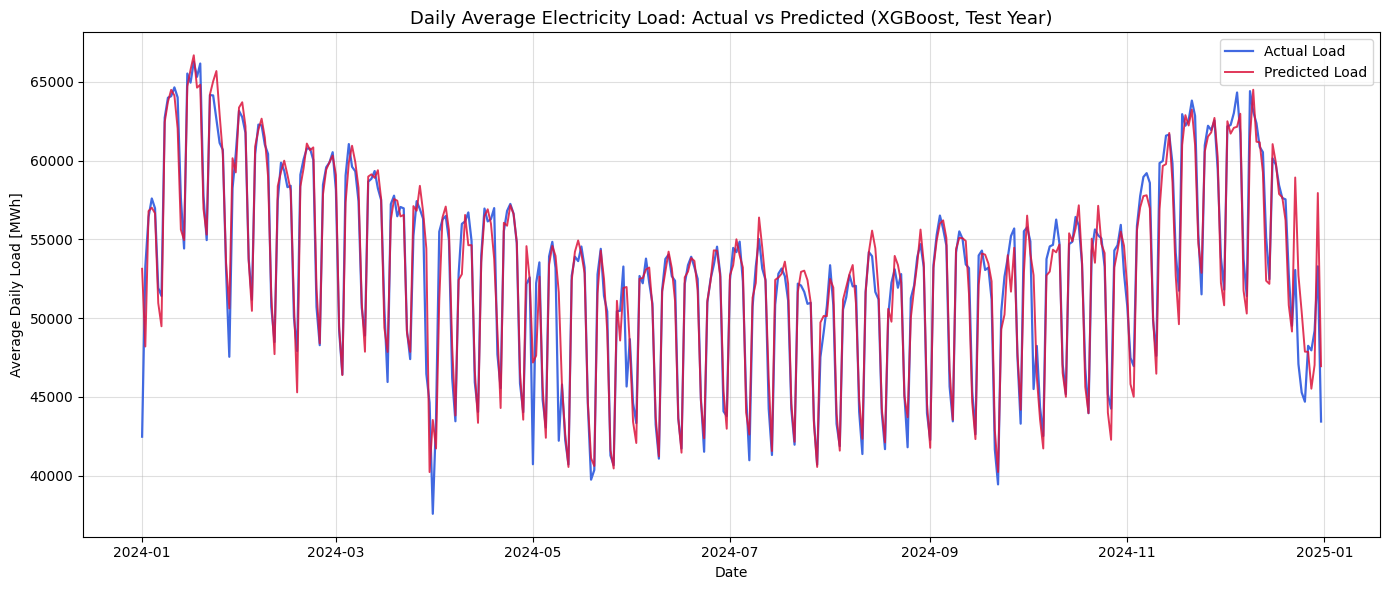

In [ ]:
results_df = pd.DataFrame({
    "timestamp": test_df["timestamp"][:len(preds)],
    "Actual_Load_MWh": truth,
    "Predicted_Load_MWh": preds
})

results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])
daily_df = results_df.resample("D", on="timestamp").mean()

plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual Load", color="royalblue", linewidth=1.6)
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted Load", color="crimson", linewidth=1.4, alpha=0.85)
plt.title("Daily Average Electricity Load: Actual vs Predicted (XGBoost, Test Year)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Average Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

**Key Findings – Daily Average Load (Actual vs. Predicted, XGBoost)**

- The predicted load closely follows the actual load throughout the entire test year, indicating strong overall model fit.
- Seasonal patterns are accurately captured: high load levels in winter, lower levels in summer.
- The model successfully reproduces weekly cyclic fluctuations and short-term variability.
- Larger deviations occur mainly at sharp peaks and troughs, suggesting slightly reduced performance during extreme load events.
- No systematic over- or underestimation is visually observable, indicating unbiased forecasting behavior.
- Overall, the visual alignment confirms the quantitative results (RMSE: 2,208.96; MAPE: 2.82%) and demonstrates robust generalization.


#### 3.2. Horizon-Dependent Error Analysis

RMSE and MAPE are plotted across the 24-hour forecast horizon to analyze how prediction accuracy evolves with increasing lead time.


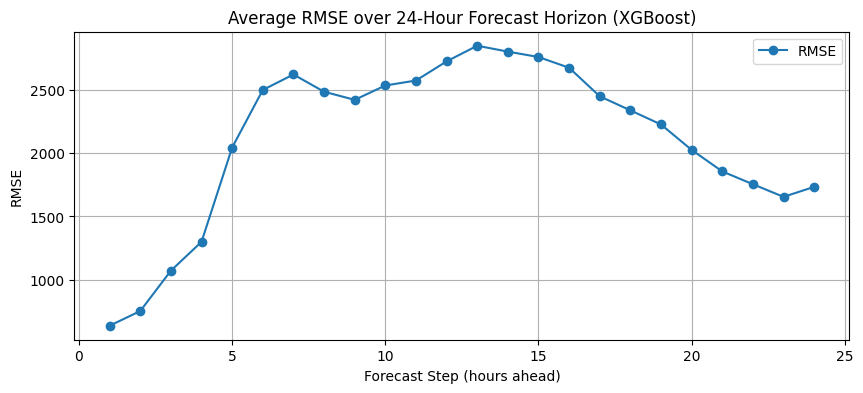

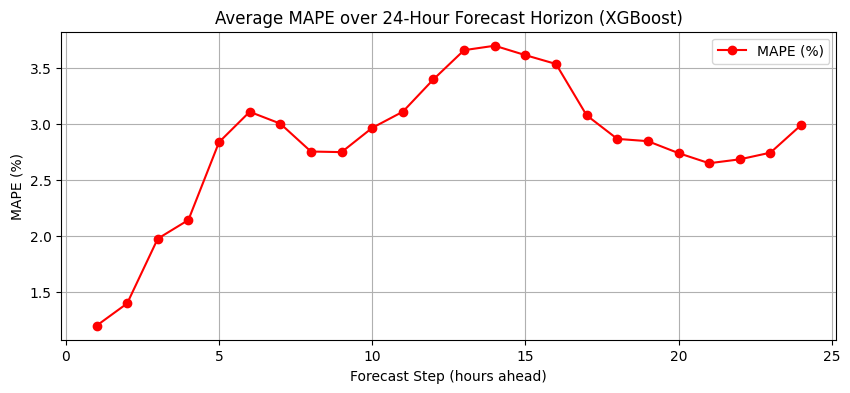

In [ ]:
# %%
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_rmse_h, marker='o', label='RMSE')
plt.title("Average RMSE over 24-Hour Forecast Horizon (XGBoost)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()



plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_mape_h, color='red', marker='o', label='MAPE (%)')
plt.title("Average MAPE over 24-Hour Forecast Horizon (XGBoost)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.show()

**Key Findings – Horizon-Dependent Error Development (XGBoost)**

- Both RMSE and MAPE increase from short horizons (h=1–4) to mid-range horizons (around h=12–15), reflecting rising forecast uncertainty.
- The highest error occurs approximately between **h=13 and h=15**, indicating maximum prediction difficulty in the mid-term range.
- After h≈16, both RMSE and MAPE gradually decline toward h=24.
- This non-linear error pattern suggests interaction effects with daily seasonality (e.g., lag_24 influence).
- Short-term forecasts (h≤3) achieve very low error levels (MAPE ≈ 1–1.5%), demonstrating excellent immediate prediction accuracy.
- Even at longer horizons, MAPE remains below 3.7%, confirming stable multi-step forecasting performance.

#### 3.3. Error Distribution per Forecast Horizon

Boxplots are generated to analyze the distribution and variability of prediction errors across different forecast steps.


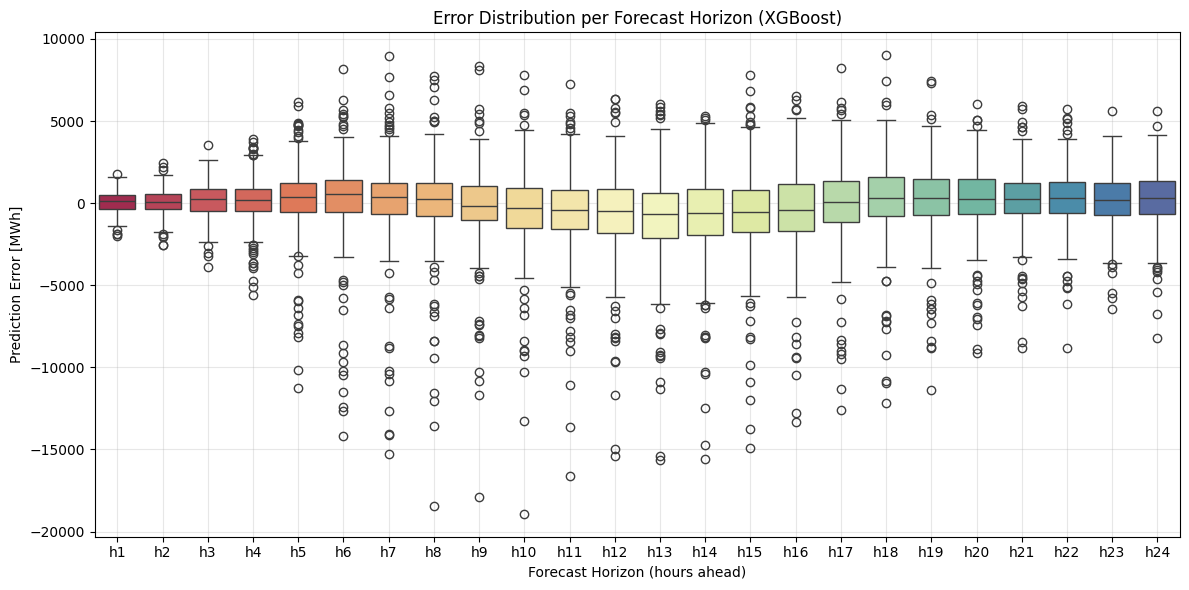

In [ ]:
# Error distribution per forecast horizon (XGBoost)

# Convert error dictionary to DataFrame
errors_df = pd.DataFrame({
    f"h{h}": errors_by_horizon[h] for h in range(1, 25)
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=errors_df, palette="Spectral")

plt.title("Error Distribution per Forecast Horizon (XGBoost)")
plt.xlabel("Forecast Horizon (hours ahead)")
plt.ylabel("Prediction Error [MWh]")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Key Findings – Error Distribution per Forecast Horizon (XGBoost)**

- Median prediction errors remain close to zero across all horizons, indicating no systematic over- or underestimation.
- Error dispersion increases from short horizons (h1–h4) to mid-range horizons (around h8–h15), reflecting higher uncertainty in medium-term forecasts.
- After approximately h16, variability stabilizes and slightly decreases toward h24.
- Extreme negative outliers occur more frequently than positive ones, suggesting occasional underestimation during peak load situations.
- Despite increasing variance at longer horizons, the interquartile ranges remain relatively compact, confirming overall stable forecasting performance.


### 4. Explainable AI: Feature Importance and SHAP (XGBoost)

To enhance model transparency and interpretability, explainable AI techniques are applied to the trained XGBoost models. Both gain-based feature importance and SHAP (SHapley Additive exPlanations) values are used to analyze the relative importance of input features and their directional impact on predictions.

While gain-based importance provides a global overview of feature relevance across all horizon-specific models, SHAP values enable a more detailed interpretation by quantifying the individual contribution of each feature to the model output. This combined approach ensures a comprehensive understanding of the model’s decision-making process and supports the interpretability of the forecasting results.

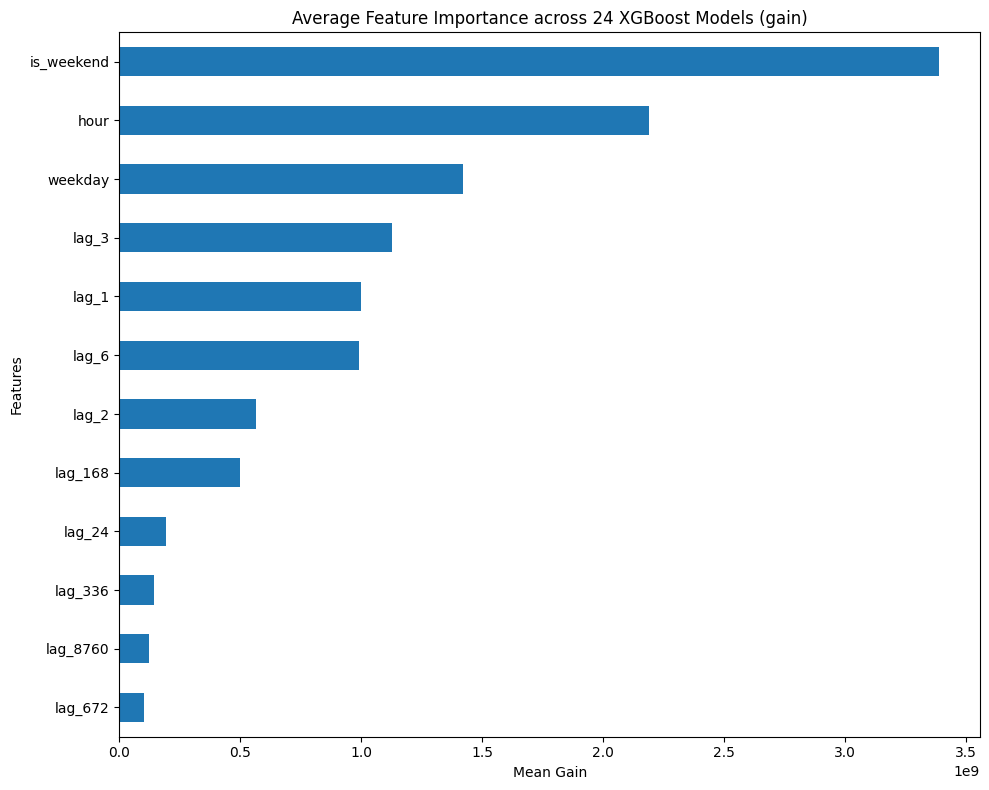

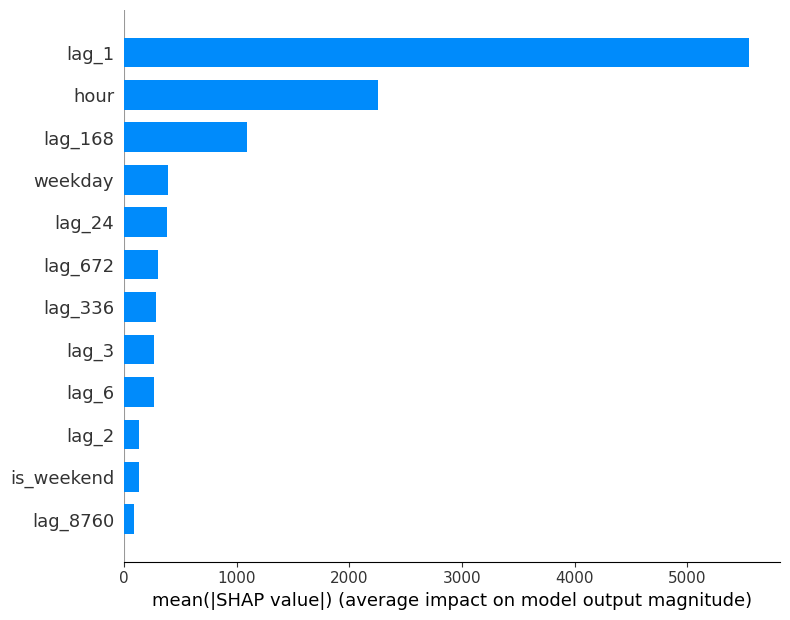

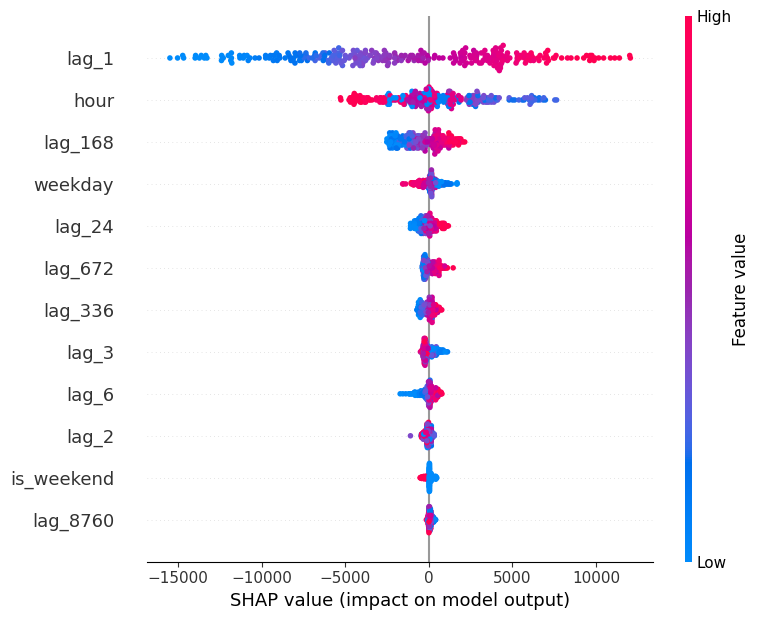

In [ ]:
# XGBoost feature importance (gain-based) aggregated across horizons
importance_df = pd.DataFrame(index=feature_cols)

for h in range(1, 25):
    booster = models_24h[h].get_booster()
    score = booster.get_score(importance_type="gain")
    imp = pd.Series(score, name=h)
    importance_df[h] = imp

importance_df = importance_df.fillna(0.0)
mean_importance = importance_df.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10,8))
mean_importance.sort_values().plot(kind="barh")
plt.title("Average Feature Importance across 24 XGBoost Models (gain)")
plt.xlabel("Mean Gain")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# SHAP for the 1-hour ahead model
model = models_24h[1]
X_sample = X_test.sample(300, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_sample, show=True)


**Key Findings – Feature Importance and SHAP Analysis (XGBoost)**

- Both gain-based importance and SHAP values identify **lag_1** as the most influential predictor, confirming strong short-term autocorrelation in electricity load.
- Temporal calendar features (**hour**, **weekday**, partly **is_weekend**) show high importance, highlighting pronounced intra-day and weekly seasonality.
- The weekly lag (**lag_168**) contributes meaningfully, indicating recurring weekly demand structures.
- Longer seasonal lags (e.g., **lag_336**, **lag_672**, **lag_8760**) have comparatively low impact, suggesting limited relevance of long-term historical effects within the 24-hour horizon.
- SHAP summary plots show a clear monotonic pattern for **lag_1**: higher lag values increase predicted load, while lower values decrease it, indicating stable and interpretable model behavior.
- Overall, the model relies primarily on **recent load information and calendar effects**, consistent with short-term load forecasting theory.



## Overall Conclusion – XGBoost Model

The multi-horizon XGBoost approach demonstrates strong and robust forecasting performance for short-term electricity load prediction. With an overall RMSE of 2,208.96 MWh and a MAPE of 2.82%, the model achieves the best generalization performance among all evaluated approaches. The results indicate that gradient boosting combined with autoregressive and calendar-based features is particularly well suited for structured short-term load forecasting tasks.
